### MVP Isochrome Plots - V1.0

- geocoding documentation: https://openrouteservice.org/dev/#/api-docs/geocode/search/get
- isochrome documentation: https://openrouteservice.org/dev/#/api-docs/v2/isochrones/{profile}/post

In [74]:
import geopandas as gpd 
import pandas as pd
import numpy as np
import requests
import json
import os
import sys 
import matplotlib.pyplot as plt
from openrouteservice import client
import folium
import shapely
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar


In [2]:
#Geocoding
key = '5b3ce3597851110001cf624896366d86ef2d40439d52f50412724477'
ORS = client.Client(key=key)

location = ORS.pelias_search(text='71 Newark Avenue, Peterborough', size= 1, country='GBR', sources=['osm'])


In [55]:
t = [10*60]
mode = ["driving-car", "driving-hgv", "foot-walking",
        "foot-hiking", "cycling-regular", "cycling-road", "cycling-mountain",
        "cycling-electric"]

        

iso = ORS.isochrones(
        locations= [location['features'][0]['geometry']['coordinates']], 
        range = t, 
        range_type='time', 
        smoothing=1, 
        attributes=['reachfactor'],
        profile= mode[0]
)

In [56]:
print(location['features'][0]['properties']['label'], location['features'][0]['geometry']['coordinates'])

Newark Avenue, Peterborough, England, United Kingdom [-0.233882, 52.592711]


In [57]:
list(reversed(location['features'][0]['geometry']['coordinates']))

[52.592711, -0.233882]

In [64]:
# Set up folium map

map1 = folium.Map(tiles='OpenStreetMap', location=([52.592711, -0.233882]), zoom_start=13 , title= 'Map',control_scale = True, attr='Nene Valley Transport Planning', width=1200, height=700)

# Set up the apartment dictionary with real coordinates
apartments = {location['features'][0]['properties']['label']: {'location': location['features'][0]['geometry']['coordinates']}}

folium.features.GeoJson(iso, name= ' Bike - 5mins').add_to(map1) # Add GeoJson to map

folium.map.Marker(list(reversed(location['features'][0]['geometry']['coordinates'])),  # reverse coords due to weird folium lat/lon syntax
                    icon=folium.Icon(color='lightgray',
                                    icon_color='#cc0000',
                                    icon='home',
                                    prefix='fa',
                                    ),
                    popup=location['features'][0]['properties']['label'],
                    ).add_to(map1)


loc = location['features'][0]['properties']['label'] + ' - Cycle 10mins'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   


map1.get_root().html.add_child(folium.Element(title_html))

                    
folium.LayerControl().add_to(map1)

map1

- input address and geocode 
- put point into Isochrome
- Porduce map 

In [59]:
#Points to shalpely point 

l= []
for i in iso['features'][0]['geometry']['coordinates'][0]:
    l.append(shapely.geometry.Point(i[0], i[1]))

#json to geopandas
g = gpd.GeoDataFrame(location['features'][0]['properties'], index=[0])
g['geometry'] = shapely.geometry.Polygon([[p.x, p.y] for p in l])
g = g.set_crs(4326)

g = g.to_crs(3857)

<AxesSubplot:>

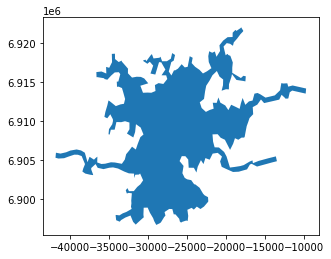

In [60]:
g.plot()

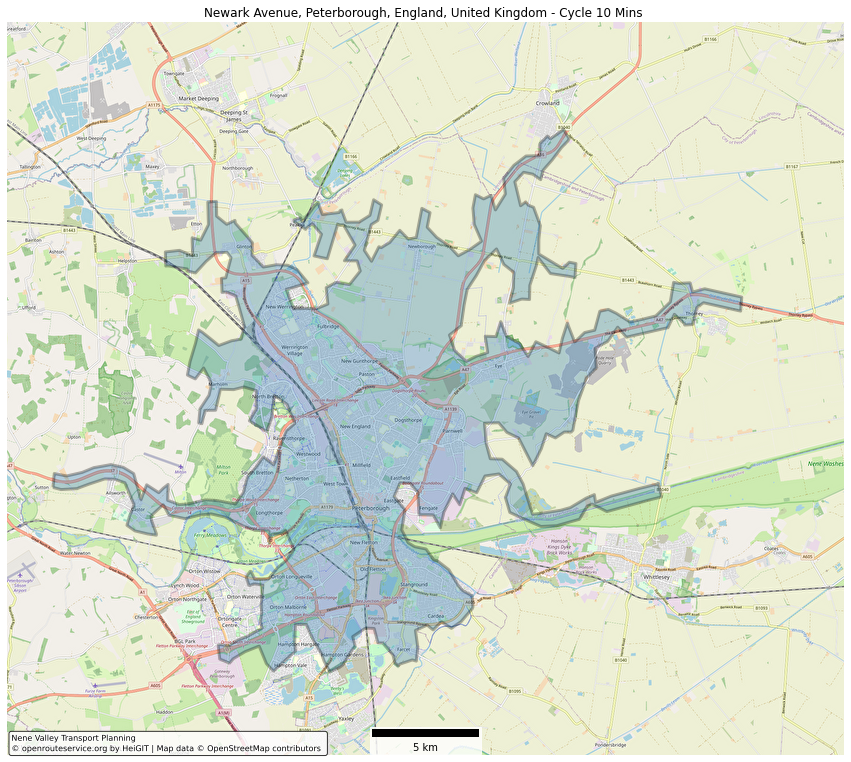

<Figure size 432x288 with 0 Axes>

In [92]:
fig, ax = plt.subplots(figsize = (15,15))

g.plot(ax=ax ,alpha=0.3, edgecolor='k', lw=3, label='Cycle 10mins')
cx.add_basemap(ax, url = cx.providers.OpenStreetMap.Mapnik, reset_extent=False, interpolation='sinc')


props = dict(boxstyle='round', facecolor='white', alpha=0.8)
cx.add_attribution(text='Nene Valley Transport Planning \n© openrouteservice.org by HeiGIT | Map data © OpenStreetMap contributors ', 
    ax=ax,bbox=props)

plt.title(location['features'][0]['properties']['label'] + ' - Cycle 10 Mins ', fontstyle=)

ax.add_artist(
    ScaleBar(1, dimension="si-length", 
    units="m",location='lower center',
    color='k', 
    box_color='white',
    box_alpha=0.8)
 )


ax.set_axis_off()
plt.show()

plt.savefig('map.png', dpi=200)

In [76]:
g.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich